# Importation des modules

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import glob
from collections import defaultdict
from operator import itemgetter
from itertools import chain
import re
from collections import Counter
import graphs

# Definition de fonctions

In [2]:
def clean_viewing_history(hist):
    liste = []
    already = []

    for elem in hist:
        inter = elem.split(':')
        if len(inter)>2:
            if re.search(r"(.*): Saison [0-9]{1,}:", elem):
                liste.append(re.findall(r"(.*): Saison [0-9]{1,}:", elem)[0])
                already.append(elem)
            elif re.search(r"(.*): Partie [0-9I]{1,}:", elem):
                liste.append(re.findall(r"(.*): Partie [0-9I]{1,}:", elem)[0])
                already.append(elem)
            elif re.search(r"(.*): Collection:", elem):
                liste.append(re.findall(r"(.*): Collection:", elem)[0])
                already.append(elem)
            else:
                liste.append(inter[0])
                already.append(elem)
        elif len(inter)!=2:
            liste.append(elem)
            already.append(elem)

    not_yet = [i for i in hist if i not in already]
    already_not_yet = Counter([i.split(':')[0] for i in not_yet]).most_common()
    already_not_yet = [i[0] for i in already_not_yet if i[1]>5]

    for elem in not_yet:
        if len(elem.split(' : '))==2:
            liste.append(elem)
        elif elem.split(':')[0] not in already_not_yet:
            liste.append(elem)

    return np.unique(liste)

def traitement_fct(filename):
    historique = pd.read_csv(filename, sep = ',').Title
    historique = [elem.replace('\xa0', ' ').replace('*', '\*') for elem in historique if 'Bande-annonce' not in elem]
    historique = [elem for elem in historique if 'Bientôt disponible' not in elem]
    historique = clean_viewing_history(historique)
    result = [(i,1) for i in historique]
    return result


def partitioner(mapped_values):
    """
    get lists from mapper and create a dict with
    (word,[1,1,1])
    """
    res = defaultdict(list)
    for w, c in mapped_values:
        res[w].append(c)
        
    return res.items()


def reducer( item ):
    """
    Compute words occurences from dict computed
    by partioner
    """
    w, v = item
    return (w,len(v))

# Importation des données

- Les titres

In [3]:
dico_id = {}
dico_title = {}

with open("../Data/Titles.txt","r", encoding = "utf-8") as f:
    for line in f.readlines():
        content = (line.replace('\n','')
                   .replace('\xa0', ' ')
                   .replace('*', '\*')
                   .split('\t'))
        
        dico_id[content[0]] = content[1]
        dico_title[content[1]] = content[0]
        
dico_title = dict(sorted(dico_title.items(), key=lambda t: t[0]))
#{key:value for key,value in dico_title.items() if key.startswith('A')}

- Le poids des noeuds

In [4]:
dico_node = {}

with open("../Data/Nodes_weight.txt","r", encoding = "utf-8") as f:
    for line in f.readlines():
        content = line.replace('\n','').split('\t')
        dico_node[content[0]] = float(content[1])
        
# dico_node

- Les liaisons

In [5]:
dico_link = {}

with open("../Data/Liaisons.txt","r", encoding = "utf-8") as f:
    for line in f.readlines():
        content = line.replace('\n','').split('\t')
        dico_link[f"{content[0]}\t{content[1]}"] = int(content[2])
        
# dico_link

# Création du graphe

In [6]:
G = nx.Graph()
for key, value in dico_node.items():
    G.add_node(key,weight=value)

In [7]:
for key, value in dico_link.items():
    ID = key.split('\t')
    G.add_edge(ID[0], ID[1], weight=value)

## Liste des fichiers csv contenant l'historique des films vu de quelques utilisateurs

In [8]:
files = sorted(glob.glob('../Data/Historiques_FilmsVu_Netflix/Historique_user*.csv'))
files

['../Data/Historiques_FilmsVu_Netflix\\Historique_user1.csv',
 '../Data/Historiques_FilmsVu_Netflix\\Historique_user2.csv',
 '../Data/Historiques_FilmsVu_Netflix\\Historique_user3.csv',
 '../Data/Historiques_FilmsVu_Netflix\\Historique_user4.csv']

In [9]:
traitement_fct(files[0])[:10]

[('3 %', 1),
 ('6 Underground', 1),
 ('Adventure Time', 1),
 ('After Life', 1),
 ('Aggretsuko', 1),
 ('Ahmed Sylla - Avec un grand A', 1),
 ('American Psycho', 1),
 ('American Vandal', 1),
 ('Ano Hi Mita Hana no Namae o Bokutachi wa Mada Shiranai', 1),
 ('Archer', 1)]

# Système de recommandation à partir d'un seul usager

In [10]:
user = int(input("Entrez un numéro d'usager que vous voulez consultez (entre 1 et 4): "))
viewing_history_user = traitement_fct(files[user-1])
viewing_history_user = [content for content,number in viewing_history_user if content in dico_title]
scores = {(f'user{user}',dico_title[i]):1.0 for i in viewing_history_user}
scores

Entrez un numéro d'usager que vous voulez consultez (entre 1 et 4): 1


{('user1', '/title/80074220/'): 1.0,
 ('user1', '/title/70241425/'): 1.0,
 ('user1', '/title/80998491/'): 1.0,
 ('user1', '/title/80198505/'): 1.0,
 ('user1', '/title/80221716/'): 1.0,
 ('user1', '/title/60000861/'): 1.0,
 ('user1', '/title/80117545/'): 1.0,
 ('user1', '/title/80075178/'): 1.0,
 ('user1', '/title/70171942/'): 1.0,
 ('user1', '/title/80117540/'): 1.0,
 ('user1', '/title/80097594/'): 1.0,
 ('user1', '/title/80178943/'): 1.0,
 ('user1', '/title/80004478/'): 1.0,
 ('user1', '/title/81060174/'): 1.0,
 ('user1', '/title/80133549/'): 1.0,
 ('user1', '/title/70204955/'): 1.0,
 ('user1', '/title/70264888/'): 1.0,
 ('user1', '/title/80988062/'): 1.0,
 ('user1', '/title/80237430/'): 1.0,
 ('user1', '/title/70304252/'): 1.0,
 ('user1', '/title/70300800/'): 1.0,
 ('user1', '/title/80235864/'): 1.0,
 ('user1', '/title/70143836/'): 1.0,
 ('user1', '/title/70281562/'): 1.0,
 ('user1', '/title/80142917/'): 1.0,
 ('user1', '/title/80185873/'): 1.0,
 ('user1', '/title/80171965/'): 1.0,
 

In [11]:
targets = [(f'user{user}',value) for key,value in dico_title.items() if key not in viewing_history_user]
targets[:5]

[('user1', '/title/80074904/'),
 ('user1', '/title/80147908/'),
 ('user1', '/title/81092768/'),
 ('user1', '/title/81092766/'),
 ('user1', '/title/80125979/')]

In [22]:
prediction = {}
for targ in targets[:5]:
    predict = graphs.item_based_collaborative_filtering(scores, targ, n_neighbors=1, graph = G)
    #if predict>=0.80:
        #prediction[(f'user{user}', targ)] = predict
    prediction[targ] = predict

In [23]:
prediction

{('user1', '/title/80074904/'): 1.0,
 ('user1', '/title/80147908/'): 1.0,
 ('user1', '/title/81092768/'): 1.0,
 ('user1', '/title/81092766/'): 1.0,
 ('user1', '/title/80125979/'): 1.0}

In [31]:
G.get_edge_data('/title/80074220/','/title/80184405/')

{'weight': 2}

In [37]:
ever_seen = [dico_title[i] for i in viewing_history_user]
dico = {}
for i in ever_seen:
    neighb = G.neighbors(i)
    dico[i] = {j:G.get_edge_data(i,j)["weight"] for j in neighb}
dico

{'/title/80074220/': {'/title/80988062/': 1,
  '/title/80029823/': 1,
  '/title/81082327/': 1,
  '/title/80097140/': 1,
  '/title/80236236/': 1,
  '/title/81093162/': 1,
  '/title/81026915/': 1,
  '/title/80022632/': 2,
  '/title/80197912/': 2,
  '/title/80178687/': 1,
  '/title/70264888/': 1,
  '/title/80077417/': 1,
  '/title/80100172/': 1,
  '/title/80066080/': 1,
  '/title/80119426/': 1,
  '/title/80174479/': 1,
  '/title/80027042/': 1,
  '/title/80097225/': 2,
  '/title/80222951/': 1,
  '/title/80105699/': 1,
  '/title/80065182/': 1,
  '/title/80174608/': 1,
  '/title/80144355/': 1,
  '/title/81004280/': 1,
  '/title/80213536/': 2,
  '/title/80202133/': 1,
  '/title/80028239/': 2,
  '/title/81000509/': 2,
  '/title/70276033/': 1,
  '/title/80189898/': 1,
  '/title/80000063/': 1,
  '/title/80035480/': 1,
  '/title/80014749/': 1,
  '/title/80171099/': 1,
  '/title/80025744/': 1,
  '/title/80084447/': 2,
  '/title/80988860/': 1,
  '/title/70158329/': 1,
  '/title/80126024/': 1,
  '/t

In [38]:
def sorted_dict(d):
    return sorted(d.items(), key=lambda t: t[1], reverse=True)

In [41]:
new_dic = {}
for key,value in dico.items():
    new_dic[key] = [i for i in sorted_dict(value) if i[1]>1]
new_dic

{'/title/80074220/': [('/title/80217315/', 3),
  ('/title/80022632/', 2),
  ('/title/80197912/', 2),
  ('/title/80097225/', 2),
  ('/title/80213536/', 2),
  ('/title/80028239/', 2),
  ('/title/81000509/', 2),
  ('/title/80084447/', 2),
  ('/title/80057281/', 2),
  ('/title/80184405/', 2),
  ('/title/80154610/', 2),
  ('/title/80208298/', 2),
  ('/title/80233215/', 2),
  ('/title/80221210/', 2),
  ('/title/80217946/', 2),
  ('/title/80107990/', 2),
  ('/title/80120485/', 2),
  ('/title/80244700/', 2),
  ('/title/80173174/', 2),
  ('/title/80218634/', 2),
  ('/title/80216621/', 2),
  ('/title/70304358/', 2),
  ('/title/80205595/', 2),
  ('/title/80220541/', 2)],
 '/title/70241425/': [('/title/80065492/', 4),
  ('/title/70155547/', 4),
  ('/title/80113201/', 4),
  ('/title/80162994/', 4),
  ('/title/70259784/', 3),
  ('/title/70237227/', 3),
  ('/title/80174479/', 3),
  ('/title/80191522/', 3),
  ('/title/80149064/', 2),
  ('/title/80006232/', 2),
  ('/title/80006168/', 2),
  ('/title/801

In [52]:
new_dico_node = {key:value for key,value in dico_node.items() if key in ever_seen}
new_dico_link = {key:value for key,value in dico_link.items() if (key.split('\t')[0] in ever_seen or key.split('\t')[1] in ever_seen)}

In [53]:
G2 = nx.Graph()
for key, value in new_dico_node.items():
    G2.add_node(key,weight=value)
for key, value in new_dico_link.items():
    ID = key.split('\t')
    G2.add_edge(ID[0], ID[1], weight=value)

In [68]:
remove = [node for node,degree in G2.degree() if degree == 0]

In [69]:
remove

['/title/80058480/']

In [70]:
G2.remove_nodes_from(remove)

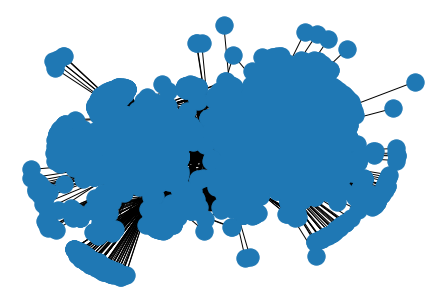

In [71]:
nx.draw(G2,pos=nx.spring_layout(G2))

In [79]:
[i for i in sorted_dict(nx.degree_centrality(G2)) if i[0] not in ever_seen]

[('/title/80213536/', 0.018035516093229745),
 ('/title/80175822/', 0.017203107658157604),
 ('/title/80095241/', 0.016925638179800223),
 ('/title/80217066/', 0.016925638179800223),
 ('/title/80092878/', 0.016925638179800223),
 ('/title/80138672/', 0.016093229744728082),
 ('/title/80175348/', 0.016093229744728082),
 ('/title/80220655/', 0.016093229744728082),
 ('/title/80057281/', 0.013318534961154274),
 ('/title/80202133/', 0.013041065482796892),
 ('/title/70143843/', 0.013041065482796892),
 ('/title/81002933/', 0.013041065482796892),
 ('/title/80176219/', 0.013041065482796892),
 ('/title/80230018/', 0.013041065482796892),
 ('/title/81000388/', 0.012763596004439512),
 ('/title/80216094/', 0.012763596004439512),
 ('/title/80223685/', 0.012763596004439512),
 ('/title/80166467/', 0.012763596004439512),
 ('/title/80994222/', 0.012763596004439512),
 ('/title/81008236/', 0.012763596004439512),
 ('/title/80210736/', 0.012763596004439512),
 ('/title/80223138/', 0.012763596004439512),
 ('/title/

In [80]:
[i for i in sorted_dict(nx.closeness_centrality(G2)) if i[0] not in ever_seen]

[('/title/80062096/', 0.4515159107992984),
 ('/title/70113007/', 0.44296951819075714),
 ('/title/70285785/', 0.4395121951219512),
 ('/title/70244165/', 0.4388165104103251),
 ('/title/80117809/', 0.43769735244109786),
 ('/title/81021976/', 0.43647813976020344),
 ('/title/80241855/', 0.4344786015672092),
 ('/title/80104068/', 0.4340077071290944),
 ('/title/80092878/', 0.43332932547793673),
 ('/title/80036148/', 0.43317307692307694),
 ('/title/80124522/', 0.43228979249130384),
 ('/title/81006261/', 0.4307398111629019),
 ('/title/80095241/', 0.4295589988081049),
 ('/title/80217066/', 0.4295589988081049),
 ('/title/80115857/', 0.4294054569283927),
 ('/title/80198142/', 0.4278760536625905),
 ('/title/70305893/', 0.4266098484848485),
 ('/title/80184405/', 0.4263070735746392),
 ('/title/80244846/', 0.4262062440870388),
 ('/title/70102569/', 0.42580340264650285),
 ('/title/70108989/', 0.4253511153074472),
 ('/title/80236253/', 0.42505012383535795),
 ('/title/11819467/', 0.425),
 ('/title/801526

In [81]:
[i for i in sorted_dict(nx.betweenness_centrality(G2)) if i[0] not in ever_seen]

[('/title/80219119/', 0.0047908554645045),
 ('/title/80062096/', 0.004541055213165793),
 ('/title/80140955/', 0.004370859248510252),
 ('/title/70202579/', 0.003999077757257635),
 ('/title/80241855/', 0.003956889262887034),
 ('/title/70285785/', 0.0035469941498692367),
 ('/title/80124522/', 0.0033758466477136445),
 ('/title/80039813/', 0.0029815271263787402),
 ('/title/80117800/', 0.002739849299930492),
 ('/title/81021976/', 0.0026095499326747947),
 ('/title/80057610/', 0.0024247571914569038),
 ('/title/80189221/', 0.002383775801669189),
 ('/title/80117809/', 0.002290722550051284),
 ('/title/80036148/', 0.0021277811931867236),
 ('/title/70259782/', 0.002085239000733611),
 ('/title/80092878/', 0.002011306593364819),
 ('/title/80095411/', 0.001950703179993397),
 ('/title/80095988/', 0.00163584955732),
 ('/title/80046249/', 0.0016159668727406082),
 ('/title/80152350/', 0.0016117849989890545),
 ('/title/81006261/', 0.0015706454577119084),
 ('/title/70221348/', 0.0015385295896214893),
 ('/ti

# Système de recommandation à partir de tous nos usagers

## Compte le nombre de fois qu'un film a été vu

In [12]:
mapped_values = map(traitement_fct, files)
partioned_values = partitioner(chain(*mapped_values))
occurences = map(reducer, partioned_values)
most_commons = sorted(occurences, key=itemgetter(1), reverse=True)

In [13]:
most_commons[:10]

[('Black Mirror', 4),
 ('Black Mirror: Bandersnatch', 4),
 ('Rick et Morty', 4),
 ('Adventure Time', 3),
 ('Archer', 3),
 ('Baby Boss : les affaires reprennent', 3),
 ('BoJack Horseman', 3),
 ('Bodyguard', 3),
 ('Breaking Bad', 3),
 ('Brooklyn Nine-Nine', 3)]

## Création dictionnaire Film : Identifiant des k films les plus vus
Les k films les plus vus par les utilisateurs dont nous disposons de leur historique

In [14]:
def id_film(liste, k):
    dico_film_id = {}
    count = 1
    for film in liste:
        if count>k:
            break
        else:
            if film[0] in dico_title:
                dico_film_id[film[0]] = dico_title[film[0]]
                count+=1
            #else:
            #   dico_film_id[film] = ''
    return dico_film_id

In [18]:
id_film(most_commons, 15)

{'Black Mirror': '/title/70264888/',
 'Black Mirror: Bandersnatch': '/title/80988062/',
 'Rick et Morty': '/title/80014749/',
 'Adventure Time': '/title/70241425/',
 'Archer': '/title/70171942/',
 'Baby Boss : les affaires reprennent': '/title/80178943/',
 'BoJack Horseman': '/title/70300800/',
 'Bodyguard': '/title/80235864/',
 'Breaking Bad': '/title/70143836/',
 'Brooklyn Nine-Nine': '/title/70281562/',
 'Dix pour cent': '/title/80133335/',
 'Désenchantée': '/title/80095697/',
 'Insatiable': '/title/80179905/',
 'La Grande Classe': '/title/81034010/',
 'MINDHUNTER': '/title/80114855/'}

## Création dictionnaire Film : Identifiant des films étant vu au moins 5 fois

In [19]:
def id_film2(liste, k):
    dico_film_id = {}
    for film in liste:
        if film[1]<k:
            break
        else:
            if film[0] in dico_title:
                dico_film_id[film[0]] = dico_title[film[0]]
            #else:
            #   dico_film_id[film] = ''
    return dico_film_id

In [21]:
id_film2(most_commons, 3)

{'Black Mirror': '/title/70264888/',
 'Black Mirror: Bandersnatch': '/title/80988062/',
 'Rick et Morty': '/title/80014749/',
 'Adventure Time': '/title/70241425/',
 'Archer': '/title/70171942/',
 'Baby Boss : les affaires reprennent': '/title/80178943/',
 'BoJack Horseman': '/title/70300800/',
 'Bodyguard': '/title/80235864/',
 'Breaking Bad': '/title/70143836/',
 'Brooklyn Nine-Nine': '/title/70281562/',
 'Dix pour cent': '/title/80133335/',
 'Désenchantée': '/title/80095697/',
 'Insatiable': '/title/80179905/',
 'La Grande Classe': '/title/81034010/',
 'MINDHUNTER': '/title/80114855/',
 'Mr. Nobody': '/title/70117580/',
 'Paradise Police': '/title/80191522/',
 'Prison Break': '/title/70140425/',
 'Sense8': '/title/80025744/',
 'Sherlock': '/title/70202589/',
 'South Park': '/title/70136107/',
 'The Good Place': '/title/80113701/',
 'The Nice Guys': '/title/80049284/',
 'Umbrella Academy': '/title/80186863/',
 'Watchmen : les gardiens': '/title/70099111/',
 'La casa de papel': '/titl

## Matrice Users-Films 
Cette matrice indique si oui ou non l'utilisateur a vu le film (1 : il a vu le film, 0 : il n'a pas vu le film)

In [16]:
id_user = []
for i in range(1, len(files)+1) :
    id_user.append(str('user'+str(i)))
    
liste_film = []
for film in id_film2.keys() :
    liste_film.append(film)

N = len(id_film2)
nb_users = len(files)

result = []

for i in range(nb_users) :
    result.append([0] * N)
    
ar = numpy.array(result)
matrice_user_films = pd.DataFrame(ar, index=id_user, columns=liste_film) 

i=-1
for file in files :
    i+=1
    for film in traitement_fct(file) :
        if film[0] in liste_film:
                matrice_user_films[film[0]][[i]]=1
                
matrice_user_films

AttributeError: 'function' object has no attribute 'keys'